# Direct S3 Access tutorial

This tutorial will show you how to authenticate with the PO.DAAC data archive, and gain access to the data in amazon S3 buckets. This allows you to natively list, copy, get data from the PO.DAAC archive using your preferred amazon methods (e.g. Python boto3, amazon SDK, aws cli).

**note** Direct S3 access is only available to users **running in AWS, us-west-2 region.** All other access must come from HTTP requests for PO.DAAC data

In [1]:
import boto3
import json
import requests
import xarray as xr
%matplotlib inline

## Get Temporary AWS Credentials for Access

S3 is an 'object store' hosted in AWS for cloud processing. Direct S3 access is achieved by passing NASA supplied temporary credentials to AWS so we can interact with S3 objects from applicable Earthdata Cloud buckets. Note, these temporary credentials are valid for only 1 hour. A netrc file is required to aquire these credentials. Use the [NASA Earthdata Authentication](https://github.com/NASA-Openscapes/2021-Cloud-Hackathon/blob/main/tutorials/04_NASA_Earthdata_Authentication.ipynb) to create a netrc file in your home directory. (Note: A NASA Earthdata Login is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.) 

The following crediential is for PODAAC, but other credentials are needed to access data from other NASA DAACs.

In [2]:
s3_cred_endpoint = 'https://archive.podaac.earthdata.nasa.gov/s3credentials'

Create a function to make a request to an endpoint for temporary credentials.

In [3]:
def get_temp_creds():
    temp_creds_url = s3_cred_endpoint
    return requests.get(temp_creds_url).json()

In [4]:
temp_creds_req = get_temp_creds()
#temp_creds_req                      # !!! BEWARE, removing the # on this line will print your temporary S3 credentials.

### List all datasets available using boto3

In [5]:
s3_client = boto3.client(
    's3',
    aws_access_key_id=temp_creds_req["accessKeyId"],
    aws_secret_access_key=temp_creds_req["secretAccessKey"],
    aws_session_token=temp_creds_req["sessionToken"]
)

In [6]:
s3_client.list_objects(Bucket="podaac-ops-cumulus-protected", Prefix="ECCO_L4_ATM_STATE_05DEG_DAILY_V4R4/")

{'ResponseMetadata': {'RequestId': '1NM9KHE62SQMWDA3',
  'HostId': '4Mq689UEnY9jo7SvuGDb/y3Go3XCNs1fjwW5TSDwWpGSqav8SGRkMetkYsIAxZLkn+tOsY4n5FU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '4Mq689UEnY9jo7SvuGDb/y3Go3XCNs1fjwW5TSDwWpGSqav8SGRkMetkYsIAxZLkn+tOsY4n5FU=',
   'x-amz-request-id': '1NM9KHE62SQMWDA3',
   'date': 'Thu, 03 Nov 2022 22:11:12 GMT',
   'x-amz-bucket-region': 'us-west-2',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'IsTruncated': True,
 'Marker': '',
 'Contents': [{'Key': 'ECCO_L4_ATM_STATE_05DEG_DAILY_V4R4/ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_1992-01-01_ECCO_V4r4_latlon_0p50deg.nc',
   'LastModified': datetime.datetime(2021, 4, 9, 17, 41, 27, tzinfo=tzlocal()),
   'ETag': '"025630c10f231882463d1a325753efaf-1"',
   'Size': 1893301,
   'StorageClass': 'STANDARD'},
  {'Key': 'ECCO_L4_ATM_STATE_05DEG_DAILY_V4R4/ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_1992-01-01_ECCO_V4r4_la

### Download a specific file within the cloud, open and plot a variable from it

In [7]:
s3_client.download_file("podaac-ops-cumulus-protected", "ECCO_L4_ATM_STATE_05DEG_DAILY_V4R4/ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_1992-01-01_ECCO_V4r4_latlon_0p50deg.nc","ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_1992-01-01_ECCO_V4r4_latlon_0p50deg.nc")

In [8]:
ds = xr.open_dataset("ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_1992-01-01_ECCO_V4r4_latlon_0p50deg.nc")
ds

<xarray.Dataset>
Dimensions:         (time: 1, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 1992-01-01T18:00:00
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] ...
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...
Dimensions without coordinates: nv
Data variables:
    EXFatemp        (time, latitude, longitude) float32 ...
    EXFaqh          (time, latitude, longitude) float32 ...
    EXFewind        (time, latitude, longitude) float32 ...
    EXFnwind        (time, latitude, longitude) float32 ...
    EXFwspee        (time, latitude, longitude) float32 ...
    EXFpress        (time, latitude, longitude) float32 ...
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-01-02T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Atmosphere Surface Temperature, Humidi...
    uuid:                         9142c796-4050-11eb-9101-0cc47a3f7ec5

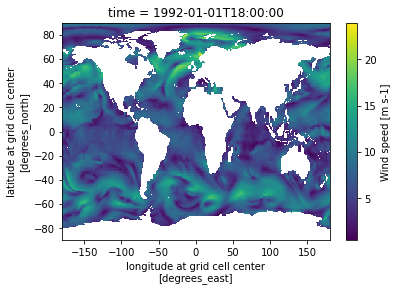

In [9]:
ds.EXFwspee.plot()

### Set up an `s3fs` session for Direct Access without downloading within the cloud
`s3fs` sessions are used for authenticated access to s3 bucket and allows for typical file-system style operations. Below we create session by passing in the temporary credentials we recieved from our temporary credentials endpoint and then find the s3 paths to the data we want.

In [10]:
import s3fs
import os

os.environ["AWS_ACCESS_KEY_ID"] = temp_creds_req["accessKeyId"]
os.environ["AWS_SECRET_ACCESS_KEY"] = temp_creds_req["secretAccessKey"]
os.environ["AWS_SESSION_TOKEN"] = temp_creds_req["sessionToken"]

s3 = s3fs.S3FileSystem(anon=False)

s3path = 's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/202101*.nc'
#s3path = 's3://podaac-ops-cumulus-protected/ECCO_L4_ATM_STATE_05DEG_DAILY_V4R4/ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_1992-01-*.nc'
remote_files = s3.glob(s3path)

In [11]:
remote_files

['podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210103090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210104090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210105090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210106090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210107090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210108090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210109090000-JPL-L4_GHRSST

In [12]:
fileset = [s3.open(file) for file in remote_files]

Open all files and combine into one `xarray` dataset

In [13]:
data = xr.open_mfdataset(fileset, combine='by_coords', engine='h5netcdf' )
data

<xarray.Dataset>
Dimensions:           (time: 31, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 2021-01-01T09:00:00 ... 2021-01-3...
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

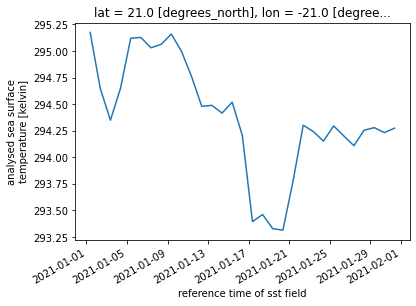

In [14]:
data.analysed_sst.sel(lat=21.00, lon=-21.00).plot()